# Part 6.

# DCGAN

Ep 1/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [1/25] | D 0.492 | G 3.191


Ep 2/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [2/25] | D 0.578 | G 3.642


Ep 3/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [3/25] | D 0.724 | G 3.352


Ep 4/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [4/25] | D 0.754 | G 2.641


Ep 5/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [5/25] | D 0.745 | G 2.449


Ep 6/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [6/25] | D 0.770 | G 2.156


Ep 7/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [7/25] | D 0.886 | G 1.848


Ep 8/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [8/25] | D 0.947 | G 1.748


Ep 9/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [9/25] | D 0.885 | G 1.778


Ep 10/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [10/25] | D 0.905 | G 1.827


Ep 11/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [11/25] | D 0.884 | G 1.807


Ep 12/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [12/25] | D 0.885 | G 1.878


Ep 13/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [13/25] | D 0.845 | G 1.903


Ep 14/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [14/25] | D 0.857 | G 1.870


Ep 15/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [15/25] | D 0.847 | G 1.884


Ep 16/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [16/25] | D 0.899 | G 1.812


Ep 17/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [17/25] | D 0.880 | G 1.823


Ep 18/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [18/25] | D 0.880 | G 1.830


Ep 19/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [19/25] | D 0.894 | G 1.821


Ep 20/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [20/25] | D 0.858 | G 1.845


Ep 21/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [21/25] | D 0.883 | G 1.808


Ep 22/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [22/25] | D 0.863 | G 1.841


Ep 23/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [23/25] | D 0.856 | G 1.862


Ep 24/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [24/25] | D 0.881 | G 1.862


Ep 25/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [25/25] | D 0.848 | G 1.863


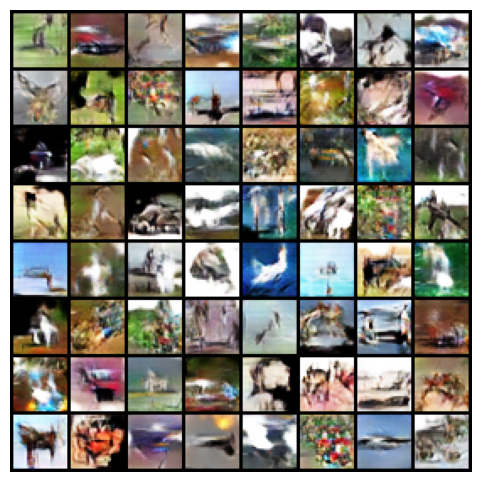

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


real:   0%|          | 0/10000 [00:00<?, ?it/s]

IS 3.57 ± 0.10


100%|██████████| 79/79 [00:35<00:00,  2.22it/s]


FID 56.98


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


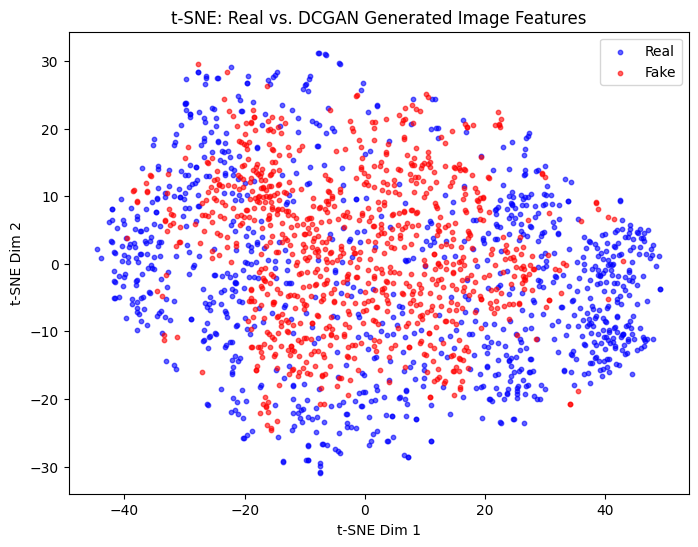

In [3]:
import importlib.util, subprocess, sys, os, shutil, torch, random, math
def need(mod, pkg):
    if importlib.util.find_spec(mod) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
need("torchmetrics","torchmetrics[image]")
need("torch_fidelity","torch-fidelity")
need("pytorch_fid","pytorch-fid")
need("tqdm","tqdm")
need("scikit-learn","scikit-learn")

from torch import nn, optim, autograd
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, utils, models
from torchmetrics.image.inception import InceptionScore
from pytorch_fid.fid_score import calculate_fid_given_paths
from sklearn.manifold import TSNE
from tqdm.auto import tqdm
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

if not (os.environ.get("COLAB_GPU") and os.environ["COLAB_GPU"]):
    raise SystemExit()

device = torch.device("cuda")
torch.backends.cudnn.benchmark = True

# Configuration parameters
cfg = dict(batch=128,
        workers=2,
        nz=100,
       ngf=64,
       ndf=64,
       epochs=25,
       lr=2e-4,
       beta1=0.5,
       real_label=0.9,
       fid_samples=10000
        )
torch.manual_seed(1337); random.seed(1337)

# Initialize weights
def init_w(m):
    if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d,nn.BatchNorm2d)):
        nn.init.normal_(m.weight,0,0.02)

def save_flat(imgs, root, start):
    root.mkdir(parents=True, exist_ok=True)
    for i, img in enumerate(imgs):
        utils.save_image(img, root/f"{start+i:05d}.png", normalize=True, value_range=(-1,1))

tx = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,)*3,(0.5,)*3)])
ds = datasets.CIFAR10("./data", download=True, transform=tx)
fixed_real, _ = next(iter(DataLoader(ds, batch_size=64, shuffle=False, num_workers=0)))

dl = DataLoader(ds, batch_size=cfg["batch"], shuffle=True, num_workers=cfg["workers"],
                persistent_workers=True, drop_last=True, pin_memory=True)

# Define Generator network
class G(nn.Module):
    def __init__(s):
        super().__init__()
        s.main = nn.Sequential(
            nn.ConvTranspose2d(cfg["nz"], cfg["ngf"]*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(cfg["ngf"]*4), nn.ReLU(True),
            nn.ConvTranspose2d(cfg["ngf"]*4, cfg["ngf"]*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(cfg["ngf"]*2), nn.ReLU(True),
            nn.ConvTranspose2d(cfg["ngf"]*2, cfg["ngf"], 4, 2, 1, bias=False),
            nn.BatchNorm2d(cfg["ngf"]), nn.ReLU(True),
            nn.ConvTranspose2d(cfg["ngf"], 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(s, z): return s.main(z)

# Define Discriminator network
class D(nn.Module):
    def __init__(s):
        super().__init__()
        s.main = nn.Sequential(
            nn.Conv2d(3, cfg["ndf"], 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(cfg["ndf"], cfg["ndf"]*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(cfg["ndf"]*2), nn.LeakyReLU(0.2, True),
            nn.Conv2d(cfg["ndf"]*2, cfg["ndf"]*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(cfg["ndf"]*4), nn.LeakyReLU(0.2, True),
            nn.Conv2d(cfg["ndf"]*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(s, x): return s.main(x).view(-1)

G, D = G().to(device).apply(init_w), D().to(device).apply(init_w)
crit = nn.BCELoss()
optG = optim.Adam(G.parameters(), lr=cfg["lr"], betas=(cfg["beta1"],0.999))
optD = optim.Adam(D.parameters(), lr=cfg["lr"], betas=(cfg["beta1"],0.999))
fixed_noise = torch.randn(64, cfg["nz"], 1, 1, device=device)

out = Path("dcgan_out"); out.mkdir(exist_ok=True)
fake_dir, real_dir = out/"fake", out/"real"
for p in (fake_dir, real_dir): shutil.rmtree(p, ignore_errors=True)

real_lbl = torch.full((cfg["batch"],), cfg["real_label"], device=device)
fake_lbl = torch.zeros(cfg["batch"], device=device)

# Training phase
for ep in range(1, cfg["epochs"]+1):
    D_sum, G_sum = 0, 0
    for real, _ in tqdm(dl, leave=False, desc=f"Ep {ep}/{cfg['epochs']}"):
        bs = real.size(0); real = real.to(device)
        # Train Discriminator
        D.zero_grad(set_to_none=True)
        z = torch.randn(bs, cfg["nz"], 1, 1, device=device)
        fake = G(z)
        lossD = crit(D(real), real_lbl[:bs]) + crit(D(fake.detach()), fake_lbl[:bs])
        lossD.backward(); optD.step()

        # Train Generator
        G.zero_grad(set_to_none=True)
        lossG = crit(D(fake), real_lbl[:bs])
        lossG.backward(); optG.step()

        D_sum += lossD.item(); G_sum += lossG.item()

    print(f"Epoch [{ep}/25] | D {D_sum/len(dl):.3f} | G {G_sum/len(dl):.3f}")

    with torch.no_grad():
        grid_fake = G(fixed_noise).cpu()
        utils.save_image(grid_fake, out/f"fake_{ep:03d}.png", nrow=8, normalize=True, value_range=(-1,1))
        utils.save_image(fixed_real, out/f"real_{ep:03d}.png", nrow=8, normalize=True, value_range=(-1,1))

plt.figure(figsize=(6,6)); plt.axis("off")
plt.imshow(utils.make_grid(grid_fake, nrow=8, normalize=True, value_range=(-1,1)).permute(1,2,0))
plt.show()

# Evaluate model using IS and FID
metric = InceptionScore(normalize=True).to(device)
saved = 0
with torch.no_grad():
    while saved < cfg["fid_samples"]:
        chunk = min(cfg["batch"], cfg["fid_samples"]-saved)
        imgs = G(torch.randn(chunk, cfg["nz"], 1, 1, device=device)).cpu()
        save_flat(imgs, fake_dir, saved)
        metric.update(imgs.to(device)); saved += imgs.size(0)

for i in tqdm(range(cfg["fid_samples"]), desc="real"):
    save_flat(ds[i][0].unsqueeze(0), real_dir, i)

# Report final scores
is_mean, is_std = metric.compute()
print(f"IS {is_mean:.2f} ± {is_std:.2f}")
fid = calculate_fid_given_paths([str(real_dir), str(fake_dir)], batch_size=128, device=device, dims=2048)
print(f"FID {fid:.2f}")

# Load pretrained ResNet18 for feature extraction
resnet = models.resnet18(pretrained=True).to(device)
feature_extractor = nn.Sequential(*list(resnet.children())[:-1]).eval()

# Normalization for ImageNet
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]
tsne_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

cifar_ds = datasets.CIFAR10("./data", train=True, download=True, transform=tsne_transform)
subset_indices = list(range(1000))
cifar_subset = Subset(cifar_ds, subset_indices)
real_loader = DataLoader(cifar_subset, batch_size=128, shuffle=False, num_workers=2)

fake_images = []
with torch.no_grad():
    for _ in range(1000 // 128):
        z = torch.randn(128, cfg["nz"], 1, 1, device=device)
        fake_batch = G(z).cpu()
        fake_batch = (fake_batch + 1.0) / 2.0

        transformed = []
        for img in fake_batch:
            img = transforms.functional.resize(img, (224,224))
            img = transforms.functional.normalize(img, mean=imagenet_mean, std=imagenet_std)
            transformed.append(img)
        fake_images.append(torch.stack(transformed))
fake_images = torch.cat(fake_images, dim=0)

real_features = []
with torch.no_grad():
    for imgs, _ in real_loader:
        feats = feature_extractor(imgs.to(device)).squeeze()
        real_features.append(feats.cpu())
real_features = torch.cat(real_features, dim=0).numpy()

fake_features = []
with torch.no_grad():
    for i in range(0, fake_images.size(0), 128):
        batch = fake_images[i:i+128].to(device)
        feats = feature_extractor(batch).squeeze()
        fake_features.append(feats.cpu())
fake_features = torch.cat(fake_features, dim=0).numpy()

# Run t-SNE on combined features
all_features = np.vstack([real_features, fake_features])
tsne = TSNE(n_components=2, perplexity=30, random_state=1337)
tsne_results = tsne.fit_transform(all_features)

# Plot t-SNE
plt.figure(figsize=(8,6))
plt.scatter(tsne_results[:1000,0], tsne_results[:1000,1], c='blue', label='Real', alpha=0.6, s=10)
plt.scatter(tsne_results[1000:,0], tsne_results[1000:,1], c='red',  label='Fake', alpha=0.6, s=10)
plt.legend()
plt.title("t-SNE: Real vs. DCGAN Generated Image Features")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()

# cGAN

Ep 1/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [1/25] | D 0.818 | G 1.888


Ep 2/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [2/25] | D 1.110 | G 1.409


Ep 3/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [3/25] | D 1.152 | G 1.316


Ep 4/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [4/25] | D 1.146 | G 1.313


Ep 5/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [5/25] | D 1.101 | G 1.321


Ep 6/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [6/25] | D 1.100 | G 1.308


Ep 7/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [7/25] | D 1.128 | G 1.278


Ep 8/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [8/25] | D 1.140 | G 1.236


Ep 9/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [9/25] | D 1.126 | G 1.254


Ep 10/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [10/25] | D 1.113 | G 1.280


Ep 11/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [11/25] | D 1.090 | G 1.305


Ep 12/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [12/25] | D 1.077 | G 1.323


Ep 13/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [13/25] | D 1.068 | G 1.355


Ep 14/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [14/25] | D 1.034 | G 1.372


Ep 15/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [15/25] | D 1.009 | G 1.415


Ep 16/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [16/25] | D 1.017 | G 1.398


Ep 17/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [17/25] | D 1.016 | G 1.412


Ep 18/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [18/25] | D 1.024 | G 1.413


Ep 19/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [19/25] | D 1.019 | G 1.422


Ep 20/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [20/25] | D 1.010 | G 1.451


Ep 21/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [21/25] | D 0.985 | G 1.479


Ep 22/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [22/25] | D 0.968 | G 1.502


Ep 23/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [23/25] | D 0.946 | G 1.542


Ep 24/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [24/25] | D 0.928 | G 1.567


Ep 25/25:   0%|          | 0/390 [00:00<?, ?it/s]

Epoch [25/25] | D 0.922 | G 1.604


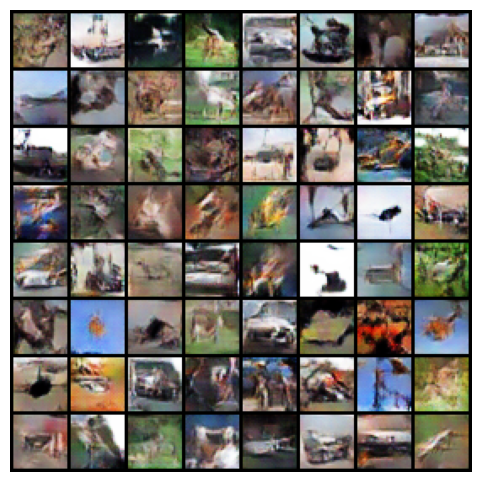

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:43: UserWarning: Metric `InceptionScore` will save all extracted features in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


real:   0%|          | 0/10000 [00:00<?, ?it/s]

IS 3.16 ± 0.03


100%|██████████| 79/79 [00:36<00:00,  2.18it/s]


FID 88.66


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


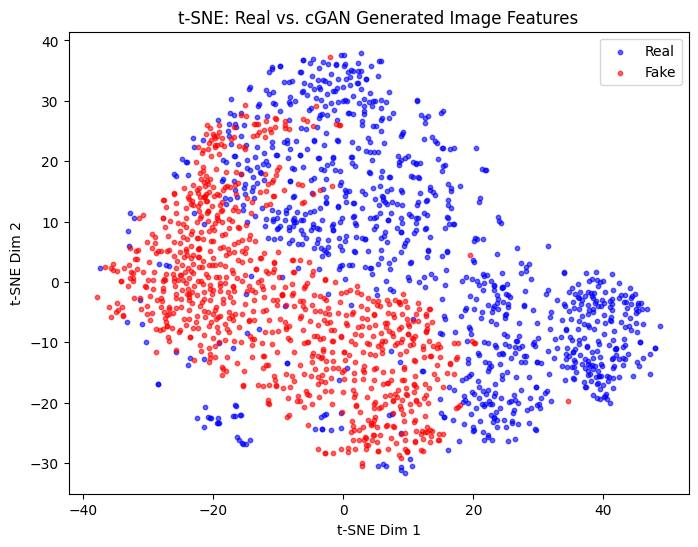

In [4]:
import importlib.util, subprocess, sys, os, shutil, torch, random, math
def need(mod, pkg):
    if importlib.util.find_spec(mod) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", pkg])
need("torchmetrics","torchmetrics[image]")
need("torch_fidelity","torch-fidelity")
need("pytorch_fid","pytorch-fid")
need("tqdm","tqdm")
need("scikit-learn","scikit-learn")

from torch import nn, optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, utils, models
from torchmetrics.image.inception import InceptionScore
from pytorch_fid.fid_score import calculate_fid_given_paths
from sklearn.manifold import TSNE
from tqdm.auto import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

if not (os.environ.get("COLAB_GPU") and os.environ["COLAB_GPU"]):
    raise SystemExit()

device = torch.device("cuda")
torch.backends.cudnn.benchmark = True

# Configuration parameters
cfg = dict(
    batch=128,
    workers=2,
    nz=100,
    ngf=64,
    ndf=64,
    epochs=25,
    lr=2e-4,
    beta1=0.5,
    real_label=0.9,
    fid_samples=10000,
    num_classes=10
    )
torch.manual_seed(1337); random.seed(1337)

# Initialize weights
def init_w(m):
    if isinstance(m,(nn.Conv2d,nn.ConvTranspose2d,nn.BatchNorm2d)):
        nn.init.normal_(m.weight,0,0.02)

def save_flat(imgs, root, start):
    root.mkdir(parents=True, exist_ok=True)
    for i, img in enumerate(imgs):
        utils.save_image(img, root/f"{start+i:05d}.png", normalize=True, value_range=(-1,1))

tx = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,)*3,(0.5,)*3)])
ds = datasets.CIFAR10("./data", download=True, transform=tx)
fixed_real, fixed_labels = next(iter(DataLoader(ds, batch_size=64, shuffle=False, num_workers=0)))

dl = DataLoader(ds, batch_size=cfg["batch"], shuffle=True, num_workers=cfg["workers"],
                persistent_workers=True, drop_last=True, pin_memory=True)

# Define Generator network
class G(nn.Module):
    def __init__(s):
        super().__init__()
        s.label_emb = nn.Embedding(cfg["num_classes"], cfg["num_classes"])
        s.main = nn.Sequential(
            nn.ConvTranspose2d(cfg["nz"]+cfg["num_classes"], cfg["ngf"]*4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(cfg["ngf"]*4), nn.ReLU(True),
            nn.ConvTranspose2d(cfg["ngf"]*4, cfg["ngf"]*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(cfg["ngf"]*2), nn.ReLU(True),
            nn.ConvTranspose2d(cfg["ngf"]*2, cfg["ngf"], 4, 2, 1, bias=False),
            nn.BatchNorm2d(cfg["ngf"]), nn.ReLU(True),
            nn.ConvTranspose2d(cfg["ngf"], 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )
    def forward(s, z, labels):
        lb = s.label_emb(labels).view(-1, cfg["num_classes"], 1, 1)
        z = torch.cat([z, lb], dim=1)
        return s.main(z)

# Define Discriminator network
class D(nn.Module):
    def __init__(s):
        super().__init__()
        s.label_emb = nn.Embedding(cfg["num_classes"], cfg["num_classes"])
        s.main = nn.Sequential(
            nn.Conv2d(3+cfg["num_classes"], cfg["ndf"], 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, True),
            nn.Conv2d(cfg["ndf"], cfg["ndf"]*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(cfg["ndf"]*2), nn.LeakyReLU(0.2, True),
            nn.Conv2d(cfg["ndf"]*2, cfg["ndf"]*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(cfg["ndf"]*4), nn.LeakyReLU(0.2, True),
            nn.Conv2d(cfg["ndf"]*4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(s, x, labels):
        lb = s.label_emb(labels).view(-1, cfg["num_classes"], 1, 1)
        lb = lb.repeat(1,1,x.size(2),x.size(3))
        x = torch.cat([x, lb], dim=1)
        return s.main(x).view(-1)

G_model, D_model = G().to(device).apply(init_w), D().to(device).apply(init_w)
crit = nn.BCELoss()
optG = optim.Adam(G_model.parameters(), lr=cfg["lr"], betas=(cfg["beta1"],0.999))
optD = optim.Adam(D_model.parameters(), lr=cfg["lr"], betas=(cfg["beta1"],0.999))
fixed_noise = torch.randn(64, cfg["nz"], 1, 1, device=device)
fixed_labels_batch = fixed_labels[:64].to(device)

out = Path("cgan_out"); out.mkdir(exist_ok=True)
fake_dir, real_dir = out/"fake", out/"real"
for p in (fake_dir, real_dir): shutil.rmtree(p, ignore_errors=True)

real_lbl = torch.full((cfg["batch"],), cfg["real_label"], device=device)
fake_lbl = torch.zeros(cfg["batch"], device=device)

# Training phase
for ep in range(1, cfg["epochs"]+1):
    D_sum, G_sum = 0, 0
    for real, labels in tqdm(dl, leave=False, desc=f"Ep {ep}/{cfg['epochs']}"):
        bs = real.size(0); real = real.to(device); labels = labels.to(device)
        D_model.zero_grad(set_to_none=True)
        z = torch.randn(bs, cfg["nz"], 1, 1, device=device)
        fake = G_model(z, labels)
        lossD = crit(D_model(real, labels), real_lbl[:bs]) + crit(D_model(fake.detach(), labels), fake_lbl[:bs])
        lossD.backward(); optD.step()
        G_model.zero_grad(set_to_none=True)
        lossG = crit(D_model(fake, labels), real_lbl[:bs])
        lossG.backward(); optG.step()

        D_sum += lossD.item(); G_sum += lossG.item()

    print(f"Epoch [{ep}/25] | D {D_sum/len(dl):.3f} | G {G_sum/len(dl):.3f}")

    with torch.no_grad():
        grid_fake = G_model(fixed_noise, fixed_labels_batch).cpu()
        utils.save_image(grid_fake, out/f"fake_{ep:03d}.png", nrow=8, normalize=True, value_range=(-1,1))
        utils.save_image(fixed_real, out/f"real_{ep:03d}.png", nrow=8, normalize=True, value_range=(-1,1))

plt.figure(figsize=(6,6)); plt.axis("off")
plt.imshow(utils.make_grid(grid_fake, nrow=8, normalize=True, value_range=(-1,1)).permute(1,2,0))
plt.show()

# Evaluate model using IS and FID
metric = InceptionScore(normalize=True).to(device)
saved = 0
with torch.no_grad():
    while saved < cfg["fid_samples"]:
        chunk = min(cfg["batch"], cfg["fid_samples"]-saved)
        labels = torch.randint(0, cfg["num_classes"], (chunk,), device=device)
        imgs = G_model(torch.randn(chunk, cfg["nz"], 1, 1, device=device), labels).cpu()
        save_flat(imgs, fake_dir, saved)
        metric.update(imgs.to(device)); saved += imgs.size(0)

for i in tqdm(range(cfg["fid_samples"]), desc="real"):
    save_flat(ds[i][0].unsqueeze(0), real_dir, i)

# Report final scores
is_mean, is_std = metric.compute()
print(f"IS {is_mean:.2f} ± {is_std:.2f}")
fid = calculate_fid_given_paths([str(real_dir), str(fake_dir)], batch_size=128, device=device, dims=2048)
print(f"FID {fid:.2f}")

# Load pretrained ResNet18 for feature extraction
resnet = models.resnet18(pretrained=True).to(device)
feature_extractor = nn.Sequential(*list(resnet.children())[:-1]).eval()

# Normalization for ImageNet
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]
tsne_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)])

cifar_ds2 = datasets.CIFAR10("./data", train=True, download=True, transform=tsne_transform)
subset_indices2 = list(range(1000))
cifar_subset2 = Subset(cifar_ds2, subset_indices2)
real_loader = DataLoader(cifar_subset2, batch_size=128, shuffle=False, num_workers=2)

fake_images = []
with torch.no_grad():
    for _ in range(1000 // 128):
        labels = torch.randint(0, cfg["num_classes"], (128,), device=device)
        z = torch.randn(128, cfg["nz"], 1, 1, device=device)
        fake_batch = G_model(z, labels).cpu()
        fake_batch = (fake_batch + 1.0) / 2.0
        transformed = []
        for img in fake_batch:
            img = transforms.functional.resize(img, (224,224))
            img = transforms.functional.normalize(img, mean=imagenet_mean, std=imagenet_std)
            transformed.append(img)
        fake_images.append(torch.stack(transformed))
fake_images = torch.cat(fake_images, dim=0)

real_features = []
with torch.no_grad():
    for imgs, _ in real_loader:
        feats = feature_extractor(imgs.to(device)).squeeze()
        real_features.append(feats.cpu())
real_features = torch.cat(real_features, dim=0).numpy()

fake_features = []
with torch.no_grad():
    for i in range(0, fake_images.size(0), 128):
        batch = fake_images[i:i+128].to(device)
        feats = feature_extractor(batch).squeeze()
        fake_features.append(feats.cpu())
fake_features = torch.cat(fake_features, dim=0).numpy()

# Run t-SNE on combined features
all_features = np.vstack([real_features, fake_features])
tsne = TSNE(n_components=2, perplexity=30, random_state=1337)
tsne_results = tsne.fit_transform(all_features)

# Plot t-SNE
plt.figure(figsize=(8,6))
plt.scatter(tsne_results[:1000,0], tsne_results[:1000,1], c='blue', label='Real', alpha=0.6, s=10)
plt.scatter(tsne_results[1000:,0], tsne_results[1000:,1], c='red',  label='Fake', alpha=0.6, s=10)
plt.legend()
plt.title("t-SNE: Real vs. cGAN Generated Image Features")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.show()